<a href="https://colab.research.google.com/github/CalculatedContent/xgbwwdata/blob/main/XGBWW_Catalog_Random5_XGBoost_Accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# XGBWW catalog-driven random-per-source XGBoost benchmark

This notebook:
1. Loads the catalog DataFrame produced by `XGBWW_Dataset_Catalog_Checkpoint.ipynb`.
2. Randomly samples **5 datasets per source** (classification only).
3. Trains one XGBoost model per sampled dataset with a small CV-based round selection.
4. Reports train and test accuracies per dataset and aggregated by source.


## 1) Mount Google Drive and configure paths


In [13]:
from google.colab import drive
from pathlib import Path

# ===== USER CONFIG =====
CATALOG_CSV = Path("/content/drive/MyDrive/xgbwwdata/catalog_checkpoint/dataset_catalog.csv")
RANDOM_SEED = 42
SAMPLES_PER_SOURCE = 5
TEST_SIZE = 0.20
# =======================

drive.mount("/content/drive")
print("Catalog path:", CATALOG_CSV)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Catalog path: /content/drive/MyDrive/xgbwwdata/catalog_checkpoint/dataset_catalog.csv


## 2) Install dependencies

Use the same repository-install flow as the other Colab notebooks (no `pip install xgbwwdata`).


In [14]:
# Install xgbwwdata from a fresh clone using the repository installer script
!rm -rf /content/repo_xgbwwdata
!git clone https://github.com/CalculatedContent/xgbwwdata.git /content/repo_xgbwwdata
%run /content/repo_xgbwwdata/scripts/colab_install.py --repo /content/repo_xgbwwdata

# Notebook-specific dependencies
%pip install -q openml pmlb keel-ds xgboost scikit-learn


Cloning into '/content/repo_xgbwwdata'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 139 (delta 9), reused 0 (delta 0), pack-reused 100 (from 2)
Receiving objects: 100% (139/139), 96.38 KiB | 10.71 MiB/s, done.
Resolving deltas: 100% (46/46), done.
+ /usr/bin/python3 -m pip install -U pip setuptools wheel
+ /usr/bin/python3 -m pip install -r /content/repo_xgbwwdata/requirements.txt
+ /usr/bin/python3 -m pip install -e /content/repo_xgbwwdata --no-build-isolation --no-deps
module: <module 'xgbwwdata' from '/content/repo_xgbwwdata/src/xgbwwdata/__init__.py'>
__file__: /content/repo_xgbwwdata/src/xgbwwdata/__init__.py
__path__: ['/content/repo_xgbwwdata/src/xgbwwdata']
exports: ['Filters', 'ScanOptions', 'config', 'enable_logging', 'load_dataset', 'logging', 'registry', 'scan_datasets', 'sources']
import OK


## 3) Imports


In [15]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from xgbwwdata import Filters, load_dataset


## 4) Load catalog and pick 5 random datasets per source


In [16]:
if not CATALOG_CSV.exists():
    raise FileNotFoundError(f"Catalog not found: {CATALOG_CSV}. Run XGBWW_Dataset_Catalog_Checkpoint.ipynb first.")

df_catalog = pd.read_csv(CATALOG_CSV)
print("Catalog shape:", df_catalog.shape)

required_cols = {"dataset_uid", "source", "task_type"}
missing = required_cols - set(df_catalog.columns)
if missing:
    raise ValueError(f"Catalog is missing required columns: {missing}")

# Accuracy is for classification; keep classification-like tasks
df_cls = df_catalog[df_catalog["task_type"].astype(str).str.contains("classification", case=False, na=False)].copy()
if df_cls.empty:
    raise ValueError("No classification datasets found in catalog.")

# Sample up to SAMPLES_PER_SOURCE per source
def sample_per_source(group):
    n = min(SAMPLES_PER_SOURCE, len(group))
    return group.sample(n=n, random_state=RANDOM_SEED)

df_pick = (
    df_cls.groupby("source", group_keys=False)
    .apply(sample_per_source)
    .reset_index(drop=True)
)

print("Selected datasets:", len(df_pick))
display(df_pick[["source", "dataset_uid", "name", "task_type"]].sort_values(["source", "dataset_uid"]))


Catalog shape: (1376, 11)
Selected datasets: 24


,source,dataset_uid,name,task_type
0,amlb_openml,amlb_openml:12,mfeat-factors,classification
1,amlb_openml,amlb_openml:181,yeast,classification
3,amlb_openml,amlb_openml:23,cmc,classification
4,amlb_openml,amlb_openml:31,credit-g,classification
2,amlb_openml,amlb_openml:54,vehicle,classification
5,keel,keel:australian,australian,classification
6,keel,keel:banana,banana,classification
8,keel,keel:bands,bands,classification
9,keel,keel:bupa,bupa,classification
7,keel,keel:chess,chess,classification


## 5) Train one XGBoost model per sampled dataset and report accuracies


In [17]:
filters = Filters(
    min_rows=200,
    max_rows=60000,
    max_features=50000,
    max_dense_elements=int(2e8),
)


def fit_and_score(dataset_uid: str, source: str):
    X, y, meta = load_dataset(dataset_uid, filters=filters)

    y = np.asarray(y)
    classes, y_enc = np.unique(y, return_inverse=True)
    n_classes = len(classes)
    if n_classes < 2:
        raise ValueError(f"Dataset {dataset_uid} has <2 classes after loading.")

    stratify = y_enc if n_classes > 1 else None
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_enc, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=stratify
    )

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    if n_classes == 2:
        params = {
            "objective": "binary:logistic",
            "eval_metric": "logloss",
            "tree_method": "hist",
            "learning_rate": 0.05,
            "max_depth": 6,
            "subsample": 0.85,
            "colsample_bytree": 0.85,
            "min_child_weight": 2.0,
            "reg_lambda": 2.0,
            "seed": RANDOM_SEED,
        }
        cv = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=1200,
            nfold=5,
            stratified=True,
            early_stopping_rounds=50,
            seed=RANDOM_SEED,
            verbose_eval=False,
        )
        rounds = len(cv)
        model = xgb.train(params=params, dtrain=dtrain, num_boost_round=rounds, verbose_eval=False)

        yhat_tr = (model.predict(dtrain) >= 0.5).astype(int)
        yhat_te = (model.predict(dtest) >= 0.5).astype(int)
    else:
        params = {
            "objective": "multi:softprob",
            "num_class": n_classes,
            "eval_metric": "mlogloss",
            "tree_method": "hist",
            "learning_rate": 0.05,
            "max_depth": 7,
            "subsample": 0.9,
            "colsample_bytree": 0.9,
            "min_child_weight": 1.0,
            "reg_lambda": 1.0,
            "seed": RANDOM_SEED,
        }
        cv = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=1200,
            nfold=5,
            stratified=True,
            early_stopping_rounds=60,
            seed=RANDOM_SEED,
            verbose_eval=False,
        )
        rounds = len(cv)
        model = xgb.train(params=params, dtrain=dtrain, num_boost_round=rounds, verbose_eval=False)

        yhat_tr = np.argmax(model.predict(dtrain), axis=1)
        yhat_te = np.argmax(model.predict(dtest), axis=1)

    return {
        "source": source,
        "dataset_uid": dataset_uid,
        "dataset_name": meta.get("name"),
        "n_rows": int(meta.get("n_rows", len(y))),
        "n_features": int(meta.get("n_features", X.shape[1] if hasattr(X, "shape") else -1)),
        "n_classes": int(n_classes),
        "rounds": int(rounds),
        "train_accuracy": float(accuracy_score(y_train, yhat_tr)),
        "test_accuracy": float(accuracy_score(y_test, yhat_te)),
    }


results = []
errors = []

for row in df_pick.itertuples(index=False):
    uid = row.dataset_uid
    source = row.source
    print(f"Training: {uid}")
    try:
        results.append(fit_and_score(uid, source))
    except Exception as e:
        errors.append({"source": source, "dataset_uid": uid, "error": str(e)})
        print(f"  Skipped {uid}: {e}")

results_df = pd.DataFrame(results)
errors_df = pd.DataFrame(errors)

print("\nCompleted:", len(results_df), "datasets")
if not errors_df.empty:
    print("Errors:", len(errors_df))
    display(errors_df.head(20))

display(results_df.sort_values(["source", "test_accuracy"], ascending=[True, False]))


Training: amlb_openml:12
Training: amlb_openml:181
Training: amlb_openml:54
Training: amlb_openml:23
Training: amlb_openml:31
Training: keel:australian
Training: keel:banana
Training: keel:chess
Training: keel:bands
Training: keel:bupa
Training: libsvm:a1a.t
Training: libsvm:a2a.t
Training: libsvm:a1a
Training: libsvm:a2a
Training: openml:903
Training: openml:1048
Training: openml:703
Training: openml:1396
Training: openml:1486
Training: pmlb:GAMETES_Epistasis_2_Way_1000atts_0.4H_EDM_1_EDM_1_1
Training: pmlb:GAMETES_Epistasis_2_Way_20atts_0.1H_EDM_1_1
Training: pmlb:GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_75_EDM_2_001
Training: pmlb:GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1
Training: pmlb:GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_50_EDM_2_001

Completed: 24 datasets


,source,dataset_uid,dataset_name,n_rows,n_features,n_classes,rounds,train_accuracy,test_accuracy
0,amlb_openml,amlb_openml:12,mfeat-factors,2000,216,10,509,1.000000,0.957500
2,amlb_openml,amlb_openml:54,vehicle,846,18,4,126,1.000000,0.741176
4,amlb_openml,amlb_openml:31,credit-g,1000,61,2,87,0.921250,0.735000
1,amlb_openml,amlb_openml:181,yeast,1484,8,10,84,0.904802,0.609428
3,amlb_openml,amlb_openml:23,cmc,1473,24,3,44,0.752122,0.569492
7,keel,keel:chess,chess,2876,36,2,896,0.997391,0.991319
5,keel,keel:australian,australian,621,14,2,86,0.903226,0.816000
8,keel,keel:bands,bands,328,19,2,107,0.812977,0.757576
6,keel,keel:banana,banana,4770,2,2,254,0.717243,0.707547
9,keel,keel:bupa,bupa,310,6,2,47,0.673387,0.677419


## 6) Summary tables (train/test accuracies)


In [18]:
if results_df.empty:
    print("No successful trainings.")
else:
    summary = (
        results_df.groupby("source", as_index=False)[["train_accuracy", "test_accuracy"]]
        .agg(["mean", "std", "min", "max"])
    )
    summary.columns = ["source"] + [f"{a}_{b}" for a, b in summary.columns.tolist()[1:]]

    print("Per-dataset results:")
    display(results_df.sort_values(["source", "test_accuracy"], ascending=[True, False]))

    print("\nPer-source summary:")
    display(summary.sort_values("test_accuracy_mean", ascending=False))


Per-dataset results:


,source,dataset_uid,dataset_name,n_rows,n_features,n_classes,rounds,train_accuracy,test_accuracy
0,amlb_openml,amlb_openml:12,mfeat-factors,2000,216,10,509,1.000000,0.957500
2,amlb_openml,amlb_openml:54,vehicle,846,18,4,126,1.000000,0.741176
4,amlb_openml,amlb_openml:31,credit-g,1000,61,2,87,0.921250,0.735000
1,amlb_openml,amlb_openml:181,yeast,1484,8,10,84,0.904802,0.609428
3,amlb_openml,amlb_openml:23,cmc,1473,24,3,44,0.752122,0.569492
7,keel,keel:chess,chess,2876,36,2,896,0.997391,0.991319
5,keel,keel:australian,australian,621,14,2,86,0.903226,0.816000
8,keel,keel:bands,bands,328,19,2,107,0.812977,0.757576
6,keel,keel:banana,banana,4770,2,2,254,0.717243,0.707547
9,keel,keel:bupa,bupa,310,6,2,47,0.673387,0.677419



Per-source summary:


,source,train_accuracy_mean,train_accuracy_std,train_accuracy_min,train_accuracy_max,test_accuracy_mean,test_accuracy_std,test_accuracy_min,test_accuracy_max
2,libsvm,0.873667,0.009568,0.865490,0.886293,0.844607,0.009441,0.831776,0.852229
1,keel,0.820845,0.132754,0.673387,0.997391,0.789972,0.124227,0.677419,0.991319
3,openml,0.857428,0.243887,0.433333,1.000000,0.742941,0.265084,0.320755,0.972871
0,amlb_openml,0.915635,0.101391,0.752122,1.000000,0.722519,0.151597,0.569492,0.957500
4,pmlb,0.868750,0.084333,0.721094,0.932813,0.653750,0.079960,0.553125,0.728125


## 7) Accuracy comparison plots (train vs test)


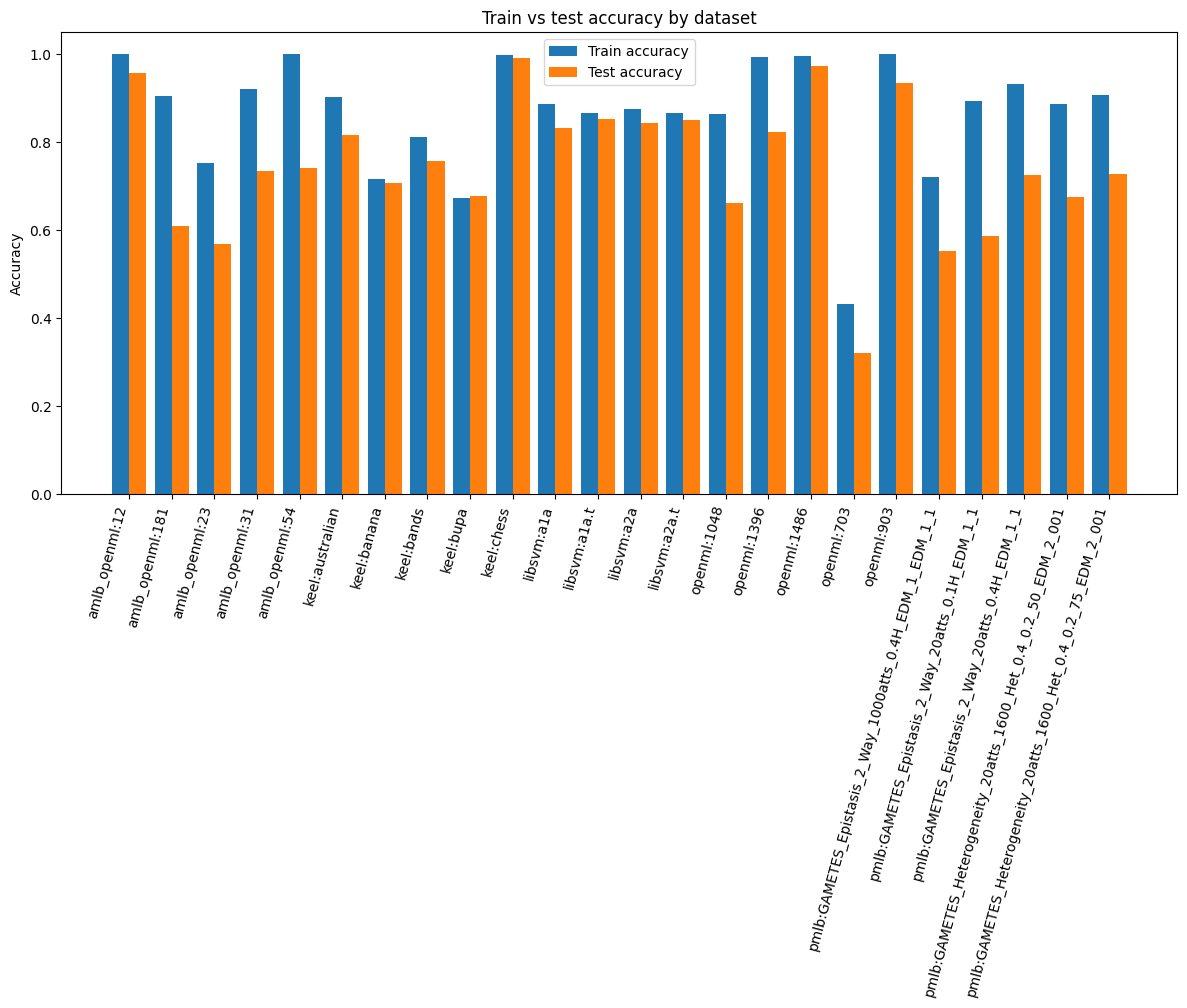

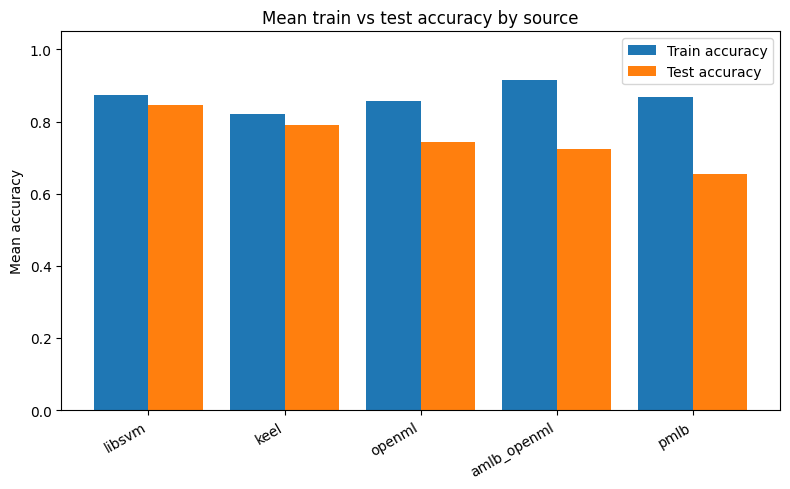

In [22]:
if results_df.empty:
    print("No successful trainings to plot.")
else:
    import matplotlib.pyplot as plt

    plot_df = results_df.sort_values(["source", "dataset_uid"]).copy()
    x = np.arange(len(plot_df))
    width = 0.4

    fig, ax = plt.subplots(figsize=(max(12, len(plot_df) * 0.6), 6))
    ax.bar(x - width / 2, plot_df["train_accuracy"], width=width, label="Train accuracy")
    ax.bar(x + width / 2, plot_df["test_accuracy"], width=width, label="Test accuracy")
    ax.set_xticks(x)
    ax.set_xticklabels(plot_df["dataset_uid"], rotation=75, ha="right")
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Accuracy")
    ax.set_title("Train vs test accuracy by dataset")
    ax.legend()
#    fig.tight_layout()
    plt.show()

    source_plot_df = (
        plot_df.groupby("source", as_index=False)[["train_accuracy", "test_accuracy"]]
        .mean()
        .sort_values("test_accuracy", ascending=False)
    )

    x2 = np.arange(len(source_plot_df))
    fig, ax = plt.subplots(figsize=(max(8, len(source_plot_df) * 1.2), 5))
    ax.bar(x2 - width / 2, source_plot_df["train_accuracy"], width=width, label="Train accuracy")
    ax.bar(x2 + width / 2, source_plot_df["test_accuracy"], width=width, label="Test accuracy")
    ax.set_xticks(x2)
    ax.set_xticklabels(source_plot_df["source"], rotation=30, ha="right")
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Mean accuracy")
    ax.set_title("Mean train vs test accuracy by source")
    ax.legend()
    fig.tight_layout()
    plt.show()

